In [1]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [3]:
import os
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from tqdm import tqdm
from warnings import filterwarnings

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob

from sklearn.model_selection import train_test_split

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
    BertTokenizer,
    BertModel,
    BertForSequenceClassification
)

from datasets import Dataset, DatasetDict

from peft import LoraConfig, PeftConfig

from trl import SFTTrainer, setup_chat_format

import bitsandbytes as bnb

from torch.utils.data import Dataset, DataLoader

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

# Preprocessing

In [9]:
data = pd.read_csv("/content/CombinedData.csv",index_col=0, sep=",")

In [10]:
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [12]:
data["status"].value_counts()

,count
status,
Normal,16351
Depression,15404
Suicidal,10653
Anxiety,3888
Bipolar,2877
Stress,2669
Personality disorder,1201


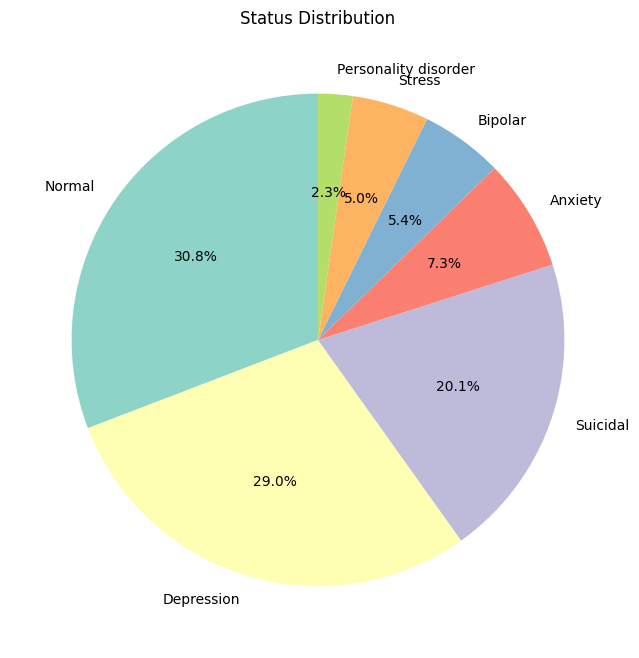

In [13]:
status_counts = data["status"].value_counts()

plt.figure(figsize=(8, 8))
status_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set3.colors,
    title="Status Distribution"
)
plt.ylabel("")
plt.show()

In [14]:
data.isna().sum()

,0
statement,362
status,0


In [15]:
data = data.dropna()

In [16]:
data.statement.duplicated(keep="first").value_counts()

,count
statement,
False,51073
True,1608


In [17]:
data = data.drop_duplicates(subset=['statement'], keep="first")

In [18]:
target_count = 5000

balanced_data = data.groupby("status").apply(
    lambda x: x.sample(min(len(x), target_count), random_state=42)
).reset_index(drop=True)

print("Original Class Distribution:")
print(data["status"].value_counts())

print("\nBalanced Class Distribution:")
print(balanced_data["status"].value_counts())

Original Class Distribution:
status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

Balanced Class Distribution:
status
Depression              5000
Suicidal                5000
Normal                  5000
Anxiety                 3617
Bipolar                 2501
Stress                  2293
Personality disorder     895
Name: count, dtype: int64


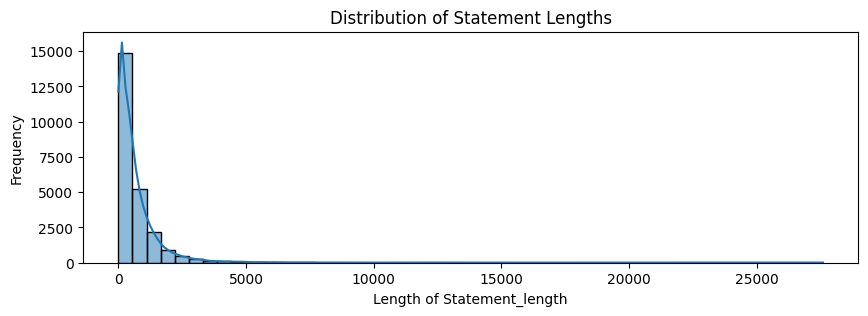

In [19]:
balanced_data['statement_length'] = balanced_data['statement'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(balanced_data['statement_length'], bins=50, kde=True)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Length of Statement_length')
plt.ylabel('Frequency')
plt.show()

In [20]:
balanced_data['words'] = [len(x.split()) for x in balanced_data['statement'].tolist()]

In [21]:
balanced_data[['words','statement']].head()

,words,statement
0,168,Fear of getting schizophrenia or any mental il...
1,201,My mind is tricking me into feeling like I nee...
2,178,Dont know whats wrong with me I really can't b...
3,78,A reminder that progress isn't linear and that...
4,185,Just had one of the worst anxiety attacks of m...


In [22]:
balanced_data['words'].describe()

,words
count,24306.00
mean,125.22
std,162.06
min,1.00
25%,23.00
50%,78.00
75%,164.00
max,5419.00


In [23]:
min_statement_size=16
balanced_data[balanced_data["words"] < min_statement_size].count()

,0
statement,4597
status,4597
statement_length,4597
words,4597


In [24]:
df = balanced_data[balanced_data['words'] > min_statement_size]

In [25]:
df['status'].value_counts()

,count
status,
Depression,4750
Suicidal,4633
Anxiety,3141
Bipolar,2480
Stress,2240
Normal,1407
Personality disorder,856


In [26]:
def preprocess_text(text):
    text = text.lower()  #Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

df['statement'] = df['statement'].apply(lambda x: preprocess_text(x))

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text

df['statement'] = remove_stopwords(df['statement'])

In [29]:
rare_values = pd.Series(' '.join(df["statement"]).split()).value_counts()[-30:]
print(len(rare_values))
df["statement"] = df["statement"].apply(lambda x: " ".join(x for x in x.split() if x not in rare_values))

30


In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [31]:
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [32]:
df['statement'] = df['statement'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

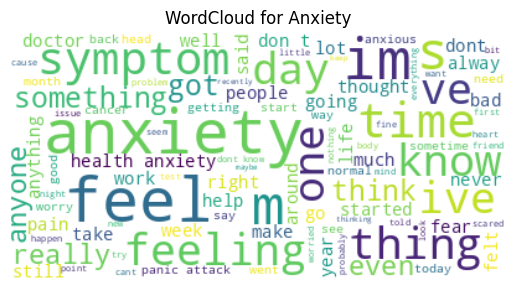

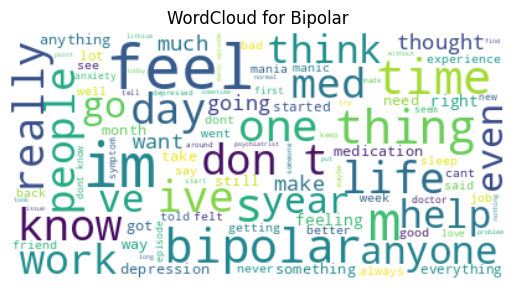

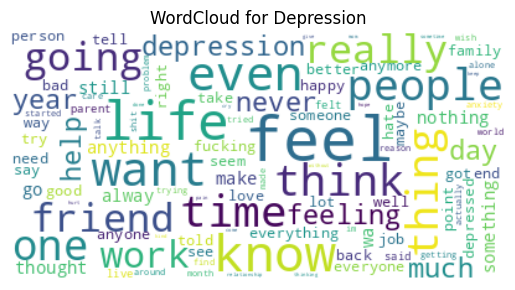

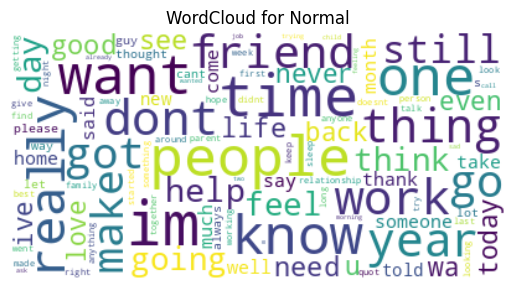

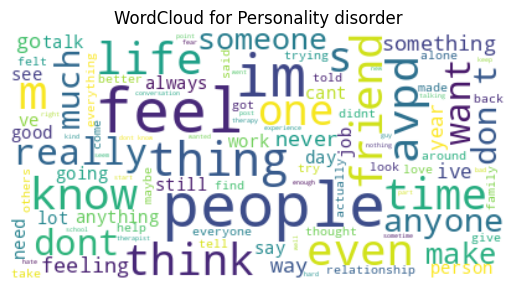

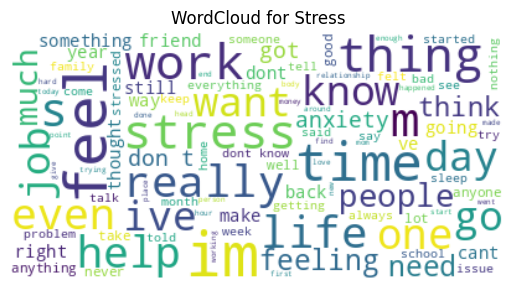

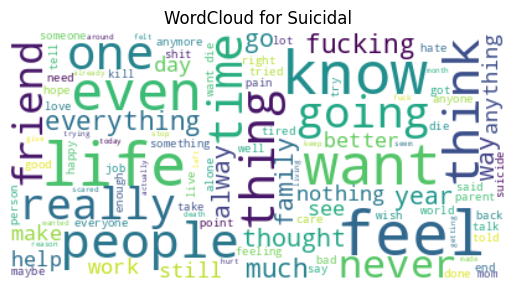

In [33]:
def generate_wordcloud(dataframe, text_column, group_column):

    groups = dataframe[group_column].unique()
    for group in groups:

        group_text = " ".join(dataframe[dataframe[group_column] == group][text_column].dropna())

        wordcloud = WordCloud(
            max_font_size=50,
            max_words=100,
            background_color="white"
        ).generate(group_text)

        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f"WordCloud for {group}")
        plt.axis("off")
        plt.show()

generate_wordcloud(df, text_column="statement", group_column="status")

In [34]:
label_map = {
    'Normal': 0,
    'Depression': 1,
    'Suicidal': 2,
    'Anxiety': 3,
    'Bipolar': 4,
    'Stress': 5,
    'Personality disorder': 6
}
df["label"] = df["status"].map(label_map)

In [35]:
df.head()

,statement,status,statement_length,words,label
0,fear getting schizophrenia mental illness psyc...,Anxiety,872,168,3
1,mind tricking feeling like need urinate couple...,Anxiety,995,201,3
2,dont know whats wrong really cant believe anxi...,Anxiety,1027,178,3
3,reminder progress isnt linear thats okay felt ...,Anxiety,396,78,3
4,one worst anxiety attack life sleep still can’...,Anxiety,949,185,3


In [36]:
df = df.drop(["statement_length", "words"], axis=1)

In [37]:
df= df.sample(frac=1)

In [38]:
df.count()

,0
statement,19507
status,19507
label,19507


# BERT

In [39]:
train_x, test_x, train_y, test_y = train_test_split( df["statement"],
                                                     df["label"],
                                                     random_state=42)

In [40]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [41]:
train_encodings = bert_tokenizer(list(train_x), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = bert_tokenizer(list(test_x), truncation=True, padding=True, max_length=128, return_tensors="pt")

In [42]:
train_labels = torch.tensor(list(train_y))
test_labels = torch.tensor(list(test_y))

In [43]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [47]:
from torch.optim import AdamW

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)
bert_model.train()

optimizer = AdamW(bert_model.parameters(), lr=5e-5)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
from torch.nn import CrossEntropyLoss

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
bert_model.to(device)

loss_fn = CrossEntropyLoss()

for epoch in range(15):
    bert_model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch + 1} tamamlandı, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1 tamamlandı, Loss: 0.9002, Accuracy: 0.6543
Epoch 2 tamamlandı, Loss: 0.5840, Accuracy: 0.7761
Epoch 3 tamamlandı, Loss: 0.4280, Accuracy: 0.8407
Epoch 4 tamamlandı, Loss: 0.2822, Accuracy: 0.8974
Epoch 5 tamamlandı, Loss: 0.1850, Accuracy: 0.9348
Epoch 6 tamamlandı, Loss: 0.1333, Accuracy: 0.9556
Epoch 7 tamamlandı, Loss: 0.0974, Accuracy: 0.9681
Epoch 8 tamamlandı, Loss: 0.0742, Accuracy: 0.9774
Epoch 9 tamamlandı, Loss: 0.0661, Accuracy: 0.9786
Epoch 10 tamamlandı, Loss: 0.0589, Accuracy: 0.9813
Epoch 11 tamamlandı, Loss: 0.0630, Accuracy: 0.9803
Epoch 12 tamamlandı, Loss: 0.0498, Accuracy: 0.9846
Epoch 13 tamamlandı, Loss: 0.0432, Accuracy: 0.9861
Epoch 14 tamamlandı, Loss: 0.0438, Accuracy: 0.9875
Epoch 15 tamamlandı, Loss: 0.0467, Accuracy: 0.9852


In [49]:
from sklearn.metrics import classification_report

bert_model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       340
           1       0.64      0.66      0.65      1187
           2       0.70      0.70      0.70      1161
           3       0.79      0.87      0.83       801
           4       0.80      0.83      0.82       610
           5       0.75      0.58      0.66       566
           6       0.64      0.64      0.64       212

    accuracy                           0.72      4877
   macro avg       0.72      0.71      0.71      4877
weighted avg       0.72      0.72      0.71      4877



In [50]:
text = "My grades are always low. I am worried about my future."

inputs = bert_tokenizer(
    text,
    max_length=128,
    truncation=True,
    padding="max_length",
    return_tensors="pt"
)

In [51]:
bert_model.eval()

inputs = {key: val.to(device) for key, val in inputs.items()}

with torch.no_grad():
    outputs = bert_model(**inputs)
    logits = outputs.logits

predicted_class = torch.argmax(logits, dim=1).item()

print("Tahmin edilen sınıf:", predicted_class)

Tahmin edilen sınıf: 3


In [52]:
label_map_inverse = {v: k for k, v in label_map.items()}

predicted_label = label_map_inverse.get(predicted_class, "Unknown")
print("Tahmin edilen etiket:", predicted_label)

Tahmin edilen etiket: Anxiety


In [53]:
llama_input = f"Text: {text}\nPredicted Label: {predicted_label}\n\nSummarize the text based on its content and predicted label."
print("Llama Model Input:", llama_input)

Llama Model Input: Text: My grades are always low. I am worried about my future.
Predicted Label: Anxiety

Summarize the text based on its content and predicted label.


In [54]:
bert_model.save_pretrained("./mental_model")

In [55]:
bert_tokenizer.save_pretrained("./mental_model")

('./mental_model/tokenizer_config.json',
 './mental_model/special_tokens_map.json',
 './mental_model/vocab.txt',
 './mental_model/added_tokens.json')

# LLM

In [ ]:
from huggingface_hub import login

login(HF_TOKEN)

In [59]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [67]:
model = model.to("cuda")

In [68]:
inputs = tokenizer(llama_input, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=256,
        num_beams=5,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Llama Model Output:", generated_text)

Llama Model Output: Text: My grades are always low. I am worried about my future.
Predicted Label: Anxiety

Summarize the text based on its content and predicted label. The text states that the speaker's grades are always low, and they are worried about their future. The predicted label is "Anxiety". This suggests that the speaker is experiencing feelings of worry and concern about their future, which are characteristic of anxiety.


In [65]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.2 MB/s eta 0:00:00


In [76]:
import gradio as gr

def classify_and_summarize(input_text):
    bert_inputs = bert_tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        bert_outputs = bert_model(**bert_inputs)
        logits = bert_outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
        predicted_class = label_map_inverse.get(predicted_class, "Unknown")
        predicted_label = f"Class {predicted_class}"

    llama_input = f"Text: {input_text}\nPredicted Label: {predicted_label}\n\nSummarize the text based on its content and predicted label."
    llama_inputs = tokenizer(llama_input, return_tensors="pt").to("cuda")

    with torch.no_grad():
        llama_outputs = model.generate(
            input_ids=llama_inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=256,
            num_beams=5,
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )
    summary = tokenizer.decode(llama_outputs[0], skip_special_tokens=True)

    return f"Predicted Label: {predicted_label}\n\nSummary: {summary}"

with gr.Blocks() as demo:
    gr.Markdown("# Ruh Sağlığı Analizi ")
    gr.Markdown("Aşağıya şikayetinizi girin ve sınıflandırmak ve özet için düğmeye tıklayınız.")

    input_text = gr.Textbox(label="Enter your text here")

    classify_button = gr.Button("Classify and Summarize")

    output_text = gr.Textbox(label="Result")

    classify_button.click(
        fn=classify_and_summarize,
        inputs=[input_text],
        outputs=[output_text]
    )

demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3b138a0d303d016721.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3b138a0d303d016721.gradio.live
